## 1. 引言

下载的轨迹数据来源真实，并非特意模拟的轨迹数据，所以质量问题十分严重，进行预处理就显得尤为重要

## 2. 裁剪

我们将下载的岳麓山轨迹数据加载入QGIS，并使用OSM作为底图：

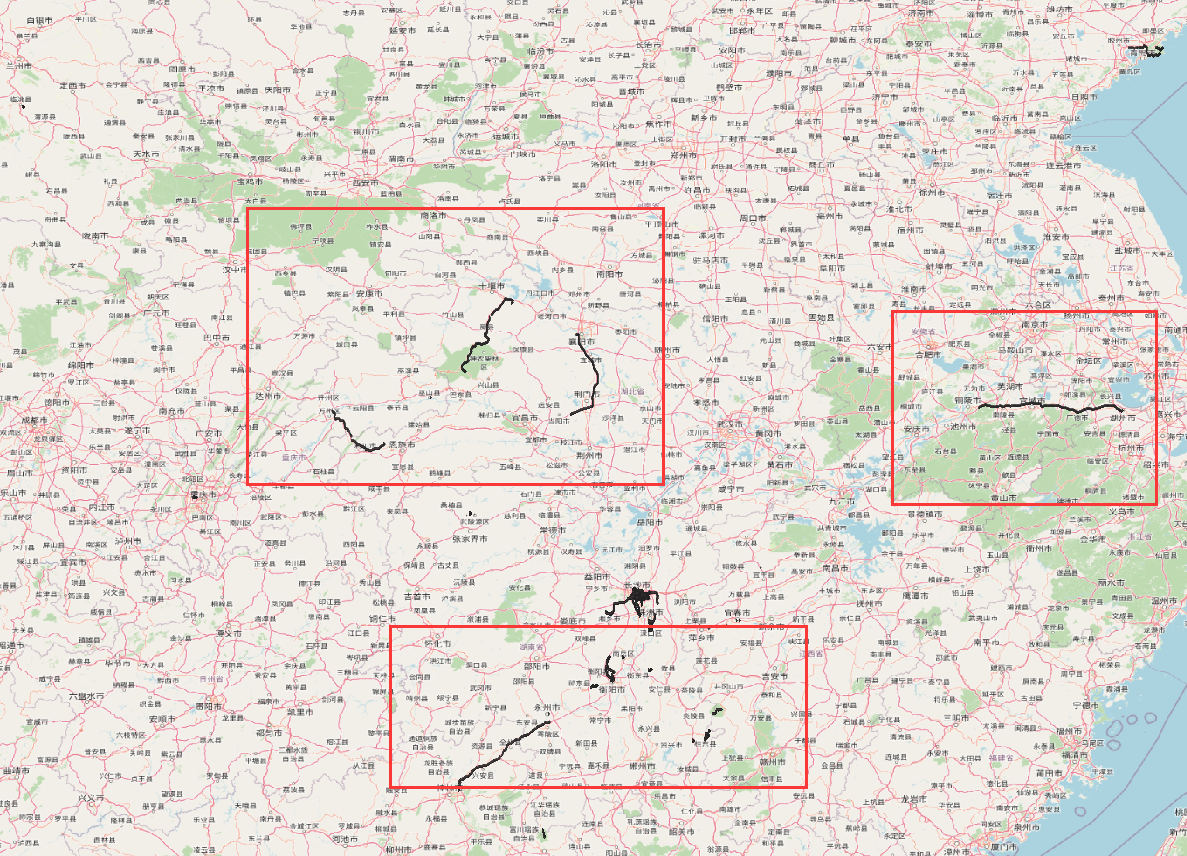

可以看到，存在着远超出长沙市范围的数据，这个是显然的必须要去除的

结合实际情况，第一次裁剪范围设置为岳麓山及周边的橘子洲、桃花岭、梅溪湖等，如图：

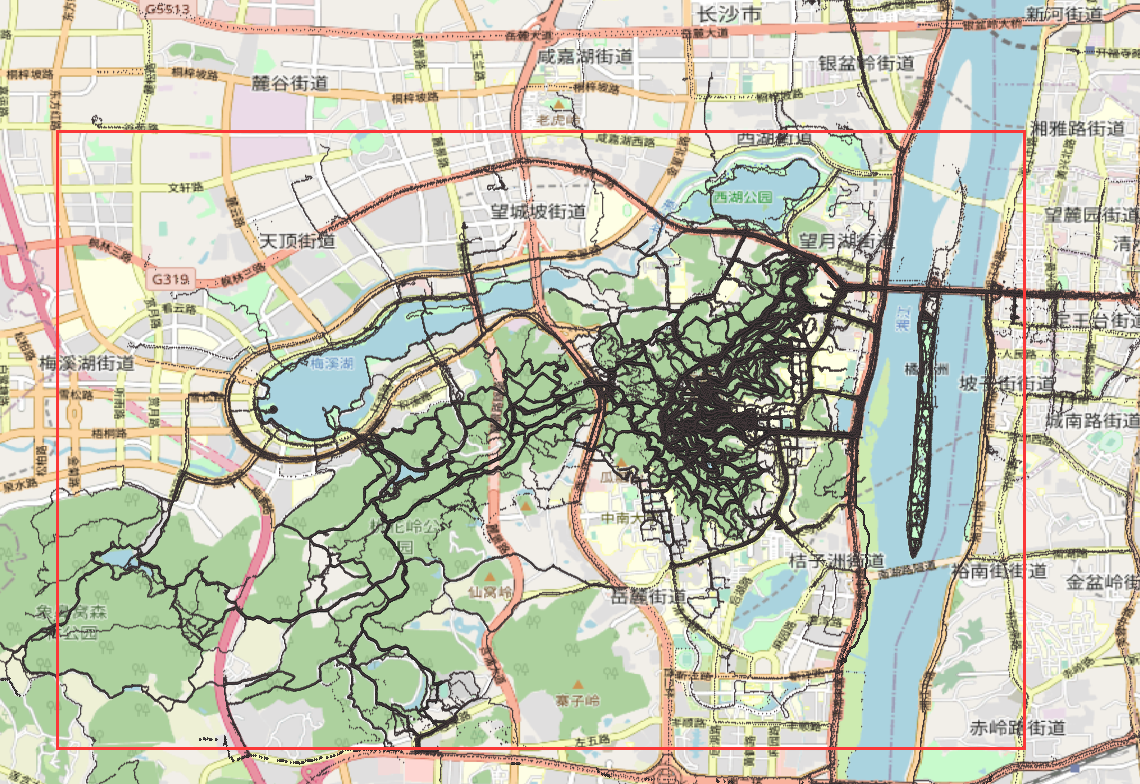

对应的分界点坐标为：
- 112.96715,28.14384 （右下）
- 112.85616,28.21707 （左上）

由于我们此次的本意（轨迹数据关键词）是岳麓山景区，第二次划分则以岳麓山景区边界为划分依据，如图所示：

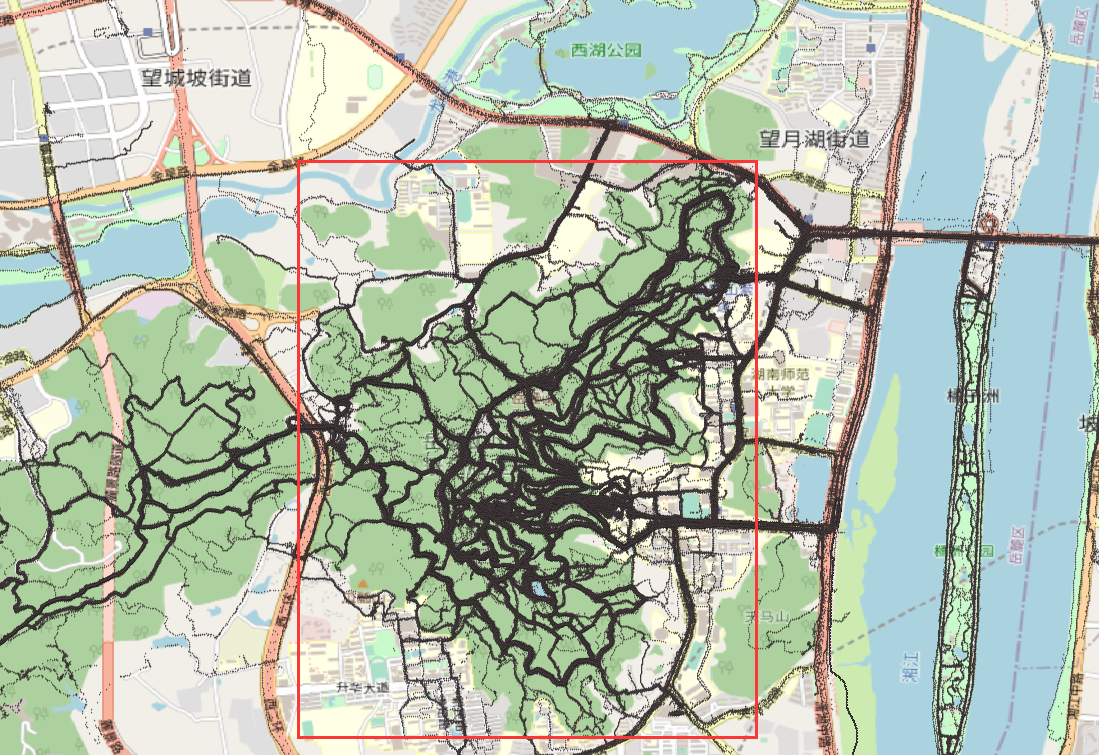

对应的分界点坐标为：
- 112.943637,28.170235 （右下）
- 112.917099,28.203567 （左上）

In [39]:
class MBR:
    def __init__(self, min_lat, min_lng, max_lat, max_lng):
        self.min_lat = min_lat
        self.min_lng = min_lng
        self.max_lat = max_lat
        self.max_lng = max_lng

    def contains(self, lat, lng):
        return self.min_lat <= lat < self.max_lat and self.min_lng <= lng < self.max_lng

 定义MBR


In [40]:
big_MBR = MBR(28.14384, 112.85616, 28.21707, 112.96715)
small_MBR = MBR(28.170235, 112.917099, 28.203567, 112.943637)


遍历文件夹中的所有文件


In [41]:
import os
file = os.listdir('./trackdata')
trip_files = []
for trip_file in file:
    if trip_file.startswith('trip_'):
        trip_files.append(trip_file)
trip_files.__len__()

1158

对每个文件中的轨迹点进行遍历，包含在MBR中就另存为

In [43]:
dir = './trackdata/'
for trip_file in trip_files:
    with open(dir+trip_file) as tf:
        # print(trip_file)
        tmp = []
        for trip_line in tf:
            point = trip_line.split(' ')
            if big_MBR.contains(float(point[0]),float(point[1])):
                tmp.append(trip_line)
        # print(len(tmp))
        if(len(tmp) > 1):
            with open(dir+'clip/'+trip_file,'w') as cf:
                cf.writelines(tmp)
            with open(dir+'clip/all.csv','a') as af:
                af.writelines(tmp)
        # print(trip_file)

以上是对大的范围剪裁，裁减结果如图：

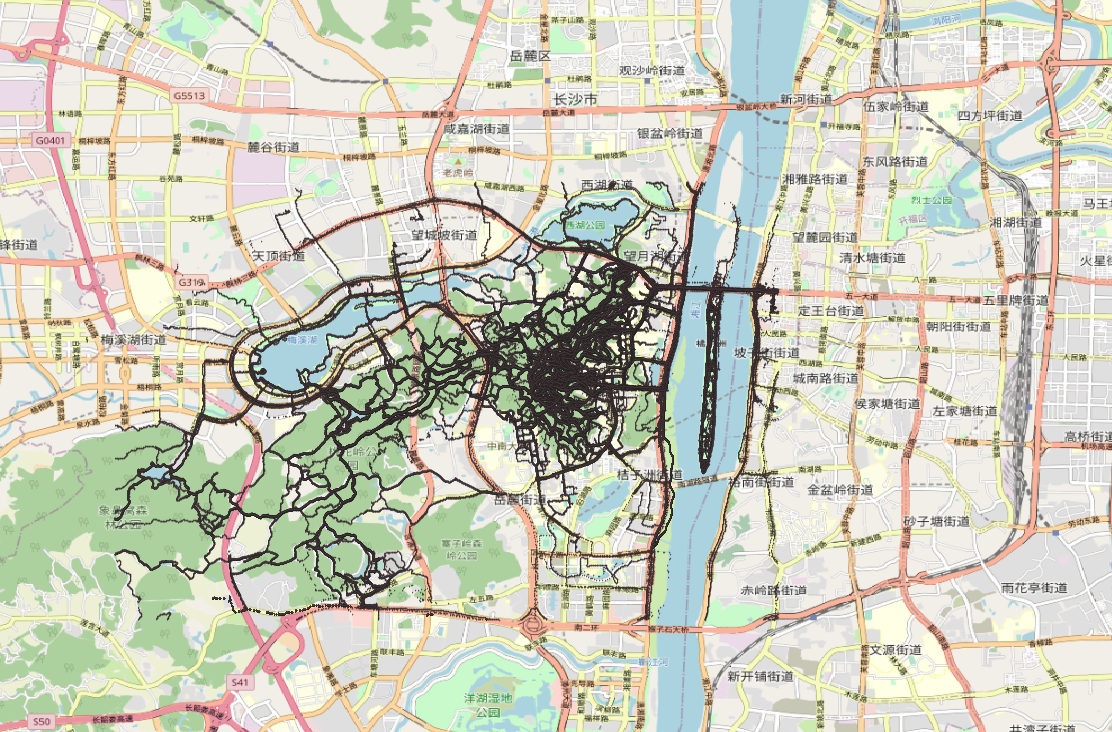

In [44]:
dir = './trackdata/'
for trip_file in trip_files:
    with open(dir+trip_file) as tf:
        # print(trip_file)
        tmp = []
        for trip_line in tf:
            point = trip_line.split(' ')
            if small_MBR.contains(float(point[0]),float(point[1])):
                tmp.append(trip_line)
        # print(len(tmp))
        if(len(tmp) > 1):
            with open(dir+'clip_yuelushan/'+trip_file,'w') as cf:
                cf.writelines(tmp)
            with open(dir+'clip_yulushan/all.csv','a') as af:
                af.writelines(tmp)

以上是对岳麓山进行裁减，结果如图：

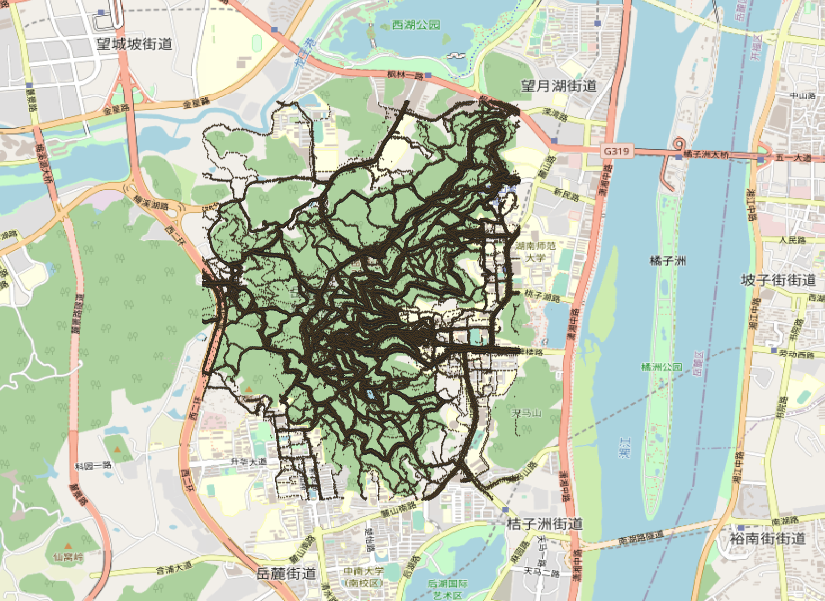

不妨将裁减的轨迹放入KDE程序中运行，得到KDE图像：

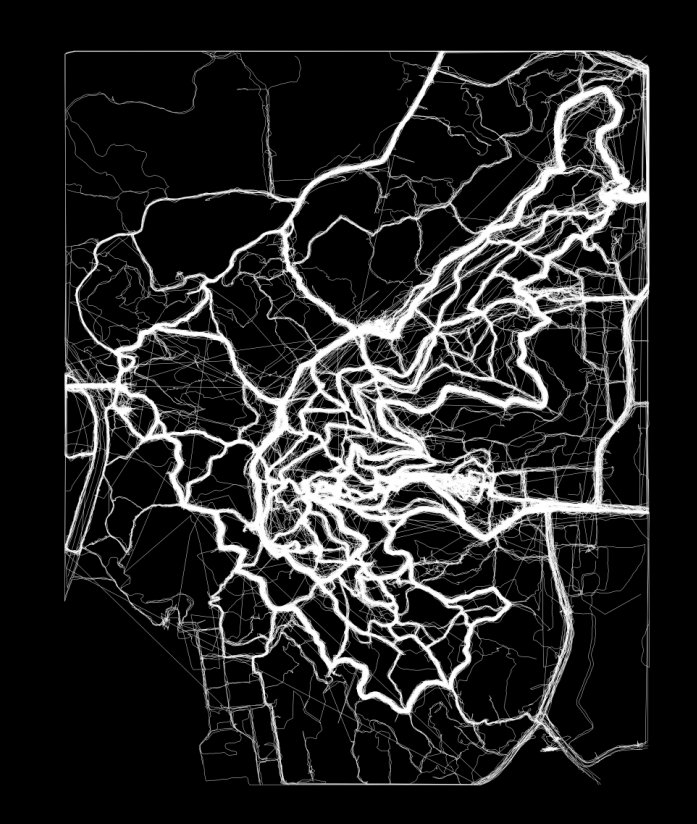


看到跳来跳去的线，显然下一步的工作是跳跃点去除

## 3. 跳跃点去除

前后点之间距离过大视为跳跃点，将这两点切断，该轨迹后面的点设为新的轨迹

定义包含距离计算的实体类：

In [1]:
import math
EARTH_MEAN_RADIUS_METER = 6371008.7714

class SPoint:
    def __init__(self, lat, lng):
        self.lat = lat
        self.lng = lng
    def __str__(self):
        return '({},{})'.format(self.lat, self.lng)
    def __eq__(self, other):
        return self.lat == other.lat and self.lng == other.lng
    
# returns the distance in meters between two points specified in degrees (Haversine formula).
def distance(a, b):
    return haversine_distance(a, b)

def haversine_distance(a, b):
    if a.__eq__(b):
        return 0.0
    delta_lat = math.radians(b.lat - a.lat)
    delta_lng = math.radians(b.lng - a.lng)
    h = math.sin(delta_lat / 2.0) * math.sin(delta_lat / 2.0) + math.cos(math.radians(a.lat)) * math.cos(
        math.radians(b.lat)) * math.sin(delta_lng / 2.0) * math.sin(delta_lng / 2.0)
    c = 2.0 * math.atan2(math.sqrt(h), math.sqrt(1 - h))
    d = EARTH_MEAN_RADIUS_METER * c
    return d

In [2]:
distance(SPoint(28.00100,118.00001),SPoint(28.00002,118.00000))

108.97560082918801

读取文件：

In [5]:
import os
file = os.listdir('./trackdata/clip_yuelushan/')
trip_files = []
for trip_file in file:
    if trip_file.startswith('trip_'):
        trip_files.append(trip_file)
trip_files.__len__()

995

跳跃点去除：

In [19]:
dir = './trackdata/clip_yuelushan/'
MAX_SAPN = 20
for trip_file in trip_files:
    with open(dir+trip_file) as tf:
        # print(trip_file)
        tmp = []
        num = 0
        tag = ''
        lines = tf.readlines()
        for i in range(len(lines)-1):
            point1 = lines[i].split(' ')
            point2 = lines[i+1].split(' ')
            if distance(SPoint(float(point1[0]),float(point1[1])),SPoint(float(point2[0]),float(point2[1]))) < MAX_SAPN:
                tmp.append(lines[i])
            else:
                if(len(tmp) > 1):
                    if num > 0:
                        tag = '_' + str(num)
                    with open('./trackdata/'+'jumpfilter_yueluhsan/'+trip_file[:-4]+tag+'.txt','w') as cf:
                        cf.writelines(tmp)
                    with open('./trackdata/'+'jumpfilter_yueluhsan/all.csv','a') as af:
                        af.writelines(tmp)
                    num = num + 1
                tmp.clear()
        if(len(tmp) > 1):
            tmp.append(lines[len(lines)-1])
            if num > 0:
                tag = '_' + str(num)
            with open('./trackdata/'+'jumpfilter_yueluhsan/'+trip_file[:-4]+tag+'.txt','w') as cf:
                cf.writelines(tmp)
            with open('./trackdata/'+'jumpfilter_yueluhsan/all.csv','a') as af:
                af.writelines(tmp)

再运行KDE程序得到图像：

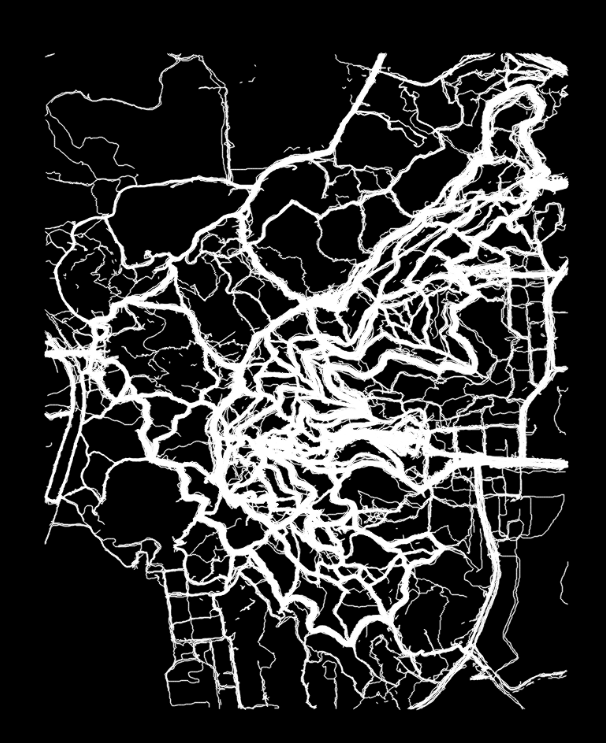

看起来似乎好多了

以下是对另一个剪裁进行跳跃点剔除：

In [3]:
import os
file = os.listdir('./trackdata/clip/')
trip_files = []
for trip_file in file:
    if trip_file.startswith('trip_'):
        trip_files.append(trip_file)
trip_files.__len__()

1013

In [4]:
dir = './trackdata/clip/'
MAX_SAPN = 20
for trip_file in trip_files:
    with open(dir+trip_file) as tf:
        # print(trip_file)
        tmp = []
        num = 0
        tag = ''
        lines = tf.readlines()
        for i in range(len(lines)-1):
            point1 = lines[i].split(' ')
            point2 = lines[i+1].split(' ')
            if distance(SPoint(float(point1[0]),float(point1[1])),SPoint(float(point2[0]),float(point2[1]))) < MAX_SAPN:
                tmp.append(lines[i])
            else:
                if(len(tmp) > 1):
                    if num > 0:
                        tag = '_' + str(num)
                    with open('./trackdata/'+'jumpfilter/'+trip_file[:-4]+tag+'.txt','w') as cf:
                        cf.writelines(tmp)
                    with open('./trackdata/'+'jumpfilter/all.csv','a') as af:
                        af.writelines(tmp)
                    num = num + 1
                tmp.clear()
        if(len(tmp) > 1):
            tmp.append(lines[len(lines)-1])
            if num > 0:
                tag = '_' + str(num)
            with open('./trackdata/'+'jumpfilter/'+trip_file[:-4]+tag+'.txt','w') as cf:
                cf.writelines(tmp)
            with open('./trackdata/'+'jumpfilter/all.csv','a') as af:
                af.writelines(tmp)

## 4. 关于滞留点

滞留点就是游客停留或者以很慢速度行走的地方，这些地方会造成点聚集，对结果有一定影响，但同时这些点也是重要的点，可以用来挖掘重要区域

## 5. 关于运动方式

运动方式其实主要是对于游客运动模式的思考，游客主要的运动方式为步行，但也有骑行、驾车、缆车等方式

可以根据速度进行一个划分，根据速度大小进行相应的剔除

考虑到实际情况，一般，景区内车辆能走的道路行人都能走，行人能走的车辆不一定能走

笔者想要的是面向行人的导航地图，所以此处笔者认为可以不处理，另外，在跳跃点剔除那里，由于手机的GPS采样时间有个默认值，我们可以认为对速度过快的也进行了剔除